In [5]:
import os, sys, gzip
import numpy as np
from six.moves import cPickle
sys.setrecursionlimit(10000)

from lasagne import layers, nonlinearities, updates, objectives, init 
from lasagne.layers import get_output, get_output_shape, get_all_params
import theano.tensor as T
import theano
from theano.tensor.shared_randomstreams import RandomStreams
from lasagne.layers import Conv2DLayer, DenseLayer, InputLayer, ExpressionLayer, BiasLayer
from lasagne.layers import NonlinearityLayer, MaxPool2DLayer, DropoutLayer, BatchNormLayer

sys.path.append('..')
from src import NeuralNet
from src import train as fit
from src import make_directory 
from models import load_model
from data import load_data

np.random.seed(247) # for reproducibility

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
%matplotlib inline
from scipy.misc import imresize

In [6]:
filename = 'Localized_N=100000_S=200_M=50_G=20_data.pickle'
datapath = '/home/peter/Data/SequenceMotif'
filepath = os.path.join(datapath, filename)

# load training set
print "loading data from: " + filepath
f = open(filepath, 'rb')
print "loading train data"
train = cPickle.load(f)
print "loading cross-validation data"
cross_validation = cPickle.load(f)
print "loading test data"
test = cPickle.load(f)
f.close()

X_train = train[0].transpose((0,1,2)).astype(np.float32)
y_train = train[1].astype(np.int32)
X_val = cross_validation[0].transpose((0,1,2)).astype(np.float32)
y_val = cross_validation[1].astype(np.int32)
X_test = test[0].transpose((0,1,2)).astype(np.float32)
y_test = test[1].astype(np.int32)

X_train = np.expand_dims(X_train, axis=3)
X_val = np.expand_dims(X_val, axis=3)
X_test = np.expand_dims(X_test, axis=3)

train = (X_train, y_train, train[2])
valid = (X_val, y_val, cross_validation[2])
test = (X_test, y_test, test[2])

shape = (None, train[0].shape[1], train[0].shape[2], train[0].shape[3])
num_labels = train[1].shape[1]

loading data from: /home/peter/Data/SequenceMotif/Localized_N=100000_S=200_M=50_G=20_data.pickle
loading train data
loading cross-validation data
loading test data


# Train classification network

In [7]:
model_name = "autoencode_motif_model"
nnmodel = NeuralNet(model_name, shape, num_labels)

In [8]:
nnmodel = fit.train_minibatch(nnmodel, train, valid, batch_size=128, num_epochs=500, 
                        patience=3, verbose=1, filepath=filepath)

Epoch 1 out of 500 
[==============================] 100.0% -- time=0s -- loss=1.71482 -- accuracy=95.19%  
  valid loss:		1.11435
  valid accuracy:	0.97424+/-0.01737
  valid auc-roc:	0.94525+/-0.06936
  valid auc-pr:		0.67841+/-0.28889
saving model parameters to: /home/peter/Data/SequenceMotif/Localized_N=100000_S=200_M=50_G=20_data.pickle_epoch_0.pickle
Epoch 2 out of 500 
[==============================] 100.0% -- time=0s -- loss=0.77073 -- accuracy=98.40%  
  valid loss:		0.54231
  valid accuracy:	0.98894+/-0.00867
  valid auc-roc:	0.98835+/-0.01920
  valid auc-pr:		0.87110+/-0.25233
saving model parameters to: /home/peter/Data/SequenceMotif/Localized_N=100000_S=200_M=50_G=20_data.pickle_epoch_1.pickle
Epoch 3 out of 500 
[==============================] 100.0% -- time=0s -- loss=0.43140 -- accuracy=99.25%  
  valid loss:		0.36083
  valid accuracy:	0.99129+/-0.00911
  valid auc-roc:	0.99575+/-0.00611
  valid auc-pr:		0.91137+/-0.20963
saving model parameters to: /home/peter/Data/Se

In [9]:
network = nnmodel.network
network

{'conv1': <lasagne.layers.dnn.Conv2DDNNLayer at 0x7f194061d950>,
 'conv1_active': <lasagne.layers.special.NonlinearityLayer at 0x7f194061db90>,
 'conv1_batch': <lasagne.layers.normalization.BatchNormLayer at 0x7f194061d290>,
 'conv1_bias': <lasagne.layers.special.BiasLayer at 0x7f194060ef50>,
 'conv1_pool': <lasagne.layers.pool.MaxPool2DLayer at 0x7f1941846250>,
 'conv2': <lasagne.layers.dnn.Conv2DDNNLayer at 0x7f1941846910>,
 'conv2_active': <lasagne.layers.special.NonlinearityLayer at 0x7f1940620310>,
 'conv2_batch': <lasagne.layers.normalization.BatchNormLayer at 0x7f1940620190>,
 'conv2_bias': <lasagne.layers.special.BiasLayer at 0x7f1940620050>,
 'conv2_pool': <lasagne.layers.pool.MaxPool2DLayer at 0x7f1940620850>,
 'conv3': <lasagne.layers.dnn.Conv2DDNNLayer at 0x7f1940620890>,
 'conv3_active': <lasagne.layers.special.NonlinearityLayer at 0x7f1940620b90>,
 'conv3_batch': <lasagne.layers.normalization.BatchNormLayer at 0x7f1940620a10>,
 'conv3_bias': <lasagne.layers.special.BiasLa

In [10]:
import pandas as pd
def seq_logo(pwm, height=100, nt_width=20, norm=0, rna=1, filepath='.'):
    """generate a sequence logo from a pwm"""
    
    def load_alphabet(filepath, rna):
        """load images of nucleotide alphabet """
        df = pd.read_table(os.path.join(filepath, 'A.txt'), header=None);
        A_img = df.as_matrix()
        A_img = np.reshape(A_img, [72, 65, 3], order="F").astype(np.uint8)

        df = pd.read_table(os.path.join(filepath, 'C.txt'), header=None);
        C_img = df.as_matrix()
        C_img = np.reshape(C_img, [76, 64, 3], order="F").astype(np.uint8)

        df = pd.read_table(os.path.join(filepath, 'G.txt'), header=None);
        G_img = df.as_matrix()
        G_img = np.reshape(G_img, [76, 67, 3], order="F").astype(np.uint8)

        if rna == 1:
            df = pd.read_table(os.path.join(filepath, 'U.txt'), header=None);
            T_img = df.as_matrix()
            T_img = np.reshape(T_img, [74, 57, 3], order="F").astype(np.uint8)
        else:
            df = pd.read_table(os.path.join(filepath, 'T.txt'), header=None);
            T_img = df.as_matrix()
            T_img = np.reshape(T_img, [72, 59, 3], order="F").astype(np.uint8)

        return A_img, C_img, G_img, T_img


    def get_nt_height(pwm, height, norm):
        """get the heights of each nucleotide"""

        def entropy(p):
            """calculate entropy of each nucleotide"""
            s = 0
            for i in range(4):
                if p[i] > 0:
                    s -= p[i]*np.log2(p[i])
            return s

        num_nt, num_seq = pwm.shape
        heights = np.zeros((num_nt,num_seq));
        for i in range(num_seq):
            if norm == 1:
                total_height = height
            else:
                total_height = (np.log2(4) - entropy(pwm[:, i]))*height;
            heights[:,i] = np.floor(pwm[:,i]*total_height);
        return heights.astype(int)

    
    # get the alphabet images of each nucleotide
    A_img, C_img, G_img, T_img = load_alphabet(filepath='.', rna=1)
    
    
    # get the heights of each nucleotide
    heights = get_nt_height(pwm, height, norm)
    
    # resize nucleotide images for each base of sequence and stack
    num_nt, num_seq = pwm.shape
    width = np.ceil(nt_width*num_seq).astype(int)
    
    total_height = np.sum(heights,axis=0)
    max_height = np.max(total_height)
    logo = np.ones((height*2, width, 3)).astype(int)*255;
    for i in range(num_seq):
        remaining_height = total_height[i];
        offset = max_height-remaining_height
        nt_height = np.sort(heights[:,i]);
        index = np.argsort(heights[:,i])

        for j in range(num_nt):
            if nt_height[j] > 0:
                # resized dimensions of image
                resize = (nt_height[j], nt_width)
                if index[j] == 0:
                    nt_img = imresize(A_img, resize)
                elif index[j] == 1:
                    nt_img = imresize(C_img, resize)
                elif index[j] == 2:
                    nt_img = imresize(G_img, resize)
                elif index[j] == 3:
                    nt_img = imresize(T_img, resize)

                # determine location of image
                height_range = range(remaining_height-nt_height[j], remaining_height)
                width_range = range(i*nt_width, i*nt_width+nt_width)

                # 'annoying' way to broadcast resized nucleotide image
                if height_range:
                    for k in range(3):
                        for m in range(len(width_range)):
                            logo[height_range+offset, width_range[m],k] = nt_img[:,m,k];

                remaining_height -= nt_height[j]

    return logo.astype(np.uint8)


/home/peter/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


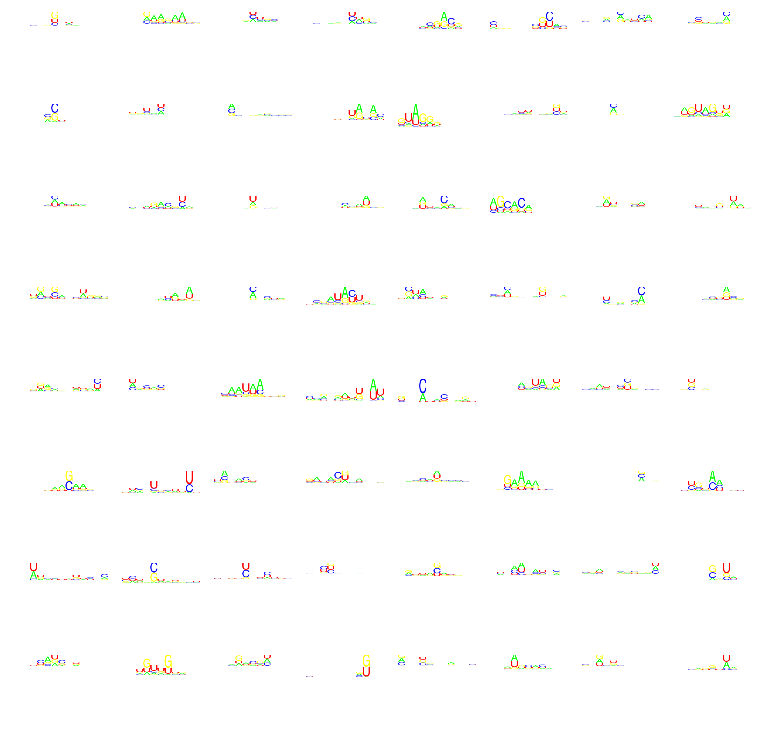

In [11]:
def plot_conv_filter(layer,size):
    W =  np.squeeze(layer.W.get_value())
    num_filters = W.shape[0]

    num_rows = int(np.ceil(np.sqrt(num_filters)))    
    grid = mpl.gridspec.GridSpec(num_rows, num_rows)
    grid.update(wspace=0.2, hspace=0.2, left=0.1, right=0.2, bottom=0.1, top=0.2) 
    
    fig = plt.figure(figsize=size);
    for i in range(num_filters):
        MIN = np.min(W[i])
        MAX = np.max(W[i])
        pwm = (W[i] - MIN)#/(MAX-MIN)
        norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
        pwm = pwm/norm

        logo = seq_logo(pwm, height=100, nt_width=25, norm=0, rna=1, filepath='.')
        plt.subplot(grid[i]);
        plt.imshow(logo);
        plt.axis('off');
    return fig, plt

fig, plt = plot_conv_filter(network['conv1'],size=(100.,100.))
fig.set_size_inches(100,100)

# Convolutional autoencoder with fixed encoder

In [12]:
from lasagne.layers import InverseLayer

In [20]:
input_var2 = T.tensor4('inputs')
deconv = {}
deconv['input'] = InputLayer(tuple(shape), input_var=input_var2)
deconv['conv1']  = Conv2DLayer(deconv['input'], num_filters=64,
                                          filter_size=(11,1),
                                          W=network['conv1'].W,
                                          b=None, 
                                          pad='same',
                                          nonlinearity=None, flip_filters=False)
deconv['conv1_bias'] = BiasLayer(deconv['conv1'], b=network['conv1_bias'].b)
deconv['conv1_norm'] = BatchNormLayer(deconv['conv1_bias'], beta=network['conv1_batch'].beta, 
                                                            gamma=network['conv1_batch'].gamma, 
                                                            mean=network['conv1_batch'].mean, 
                                                            inv_std=network['conv1_batch'].inv_std)
deconv['conv1'].params[deconv['conv1'].W].remove('trainable')
deconv['conv1_bias'].params[deconv['conv1_bias'].b].remove('trainable')
deconv['conv1_norm'].params[deconv['conv1_norm'].beta].remove('trainable')
deconv['conv1_norm'].params[deconv['conv1_norm'].gamma].remove('trainable')

deconv['conv1_active'] = NonlinearityLayer(deconv['conv1_norm'], nonlinearity=nonlinearities.rectify)
#deconv['conv1_active'] = layers.ParametricRectifierLayer(deconv['conv1_norm'], alpha=init.Constant(0.25))
deconv['conv1_pool'] = MaxPool2DLayer(deconv['conv1_active'], pool_size=(4,1))


deconv['conv2']  = Conv2DLayer(deconv['conv1_pool'], num_filters=128,
                                          filter_size=(7,1),
                                          W=network['conv2'].W,
                                          b=None, 
                                          pad='same',
                                          nonlinearity=nonlinearities.rectify, flip_filters=False)
deconv['conv2_bias'] = BiasLayer(deconv['conv2'], b=network['conv2_bias'].b)
deconv['conv2_norm'] = BatchNormLayer(deconv['conv2_bias'], beta=network['conv2_batch'].beta, 
                                                            gamma=network['conv2_batch'].gamma, 
                                                            mean=network['conv2_batch'].mean, 
                                                            inv_std=network['conv2_batch'].inv_std)
deconv['conv2_active'] = NonlinearityLayer(deconv['conv2_norm'], nonlinearity=nonlinearities.rectify)
#deconv['conv2_active'] = layers.ParametricRectifierLayer(deconv['conv2_norm'], alpha=init.Constant(0.25))
deconv['conv2_pool'] = MaxPool2DLayer(deconv['conv2_active'], pool_size=(2,1))
deconv['conv2'].params[deconv['conv2'].W].remove('trainable')
deconv['conv2_bias'].params[deconv['conv2_bias'].b].remove('trainable')
deconv['conv2_norm'].params[deconv['conv2_norm'].beta].remove('trainable')
deconv['conv2_norm'].params[deconv['conv2_norm'].gamma].remove('trainable')


deconv['conv3']  = Conv2DLayer(deconv['conv2_pool'], num_filters=256,
                                          filter_size=(5,1),
                                          W=network['conv3'].W,
                                          b=None, 
                                          pad='same',
                                          nonlinearity=None, flip_filters=False)
deconv['conv3_bias'] = BiasLayer(deconv['conv3'], b=network['conv3_bias'].b)
deconv['conv3_norm'] = BatchNormLayer(deconv['conv3_bias'], beta=network['conv3_batch'].beta, 
                                                            gamma=network['conv3_batch'].gamma, 
                                                            mean=network['conv3_batch'].mean, 
                                                            inv_std=network['conv3_batch'].inv_std)
deconv['conv3_active'] = NonlinearityLayer(deconv['conv3_norm'], nonlinearity=nonlinearities.rectify)
deconv['conv3_pool'] = MaxPool2DLayer(deconv['conv3_active'], pool_size=(5,1))
deconv['conv3'].params[deconv['conv3'].W].remove('trainable')
deconv['conv3_bias'].params[deconv['conv3_bias'].b].remove('trainable')
deconv['conv3_norm'].params[deconv['conv3_norm'].beta].remove('trainable')
deconv['conv3_norm'].params[deconv['conv3_norm'].gamma].remove('trainable')


deconv['conv4']  = Conv2DLayer(deconv['conv3_pool'], num_filters=512,
                                          filter_size=(5,1),
                                          W=network['conv4'].W,
                                          b=None, 
                                          pad='same',
                                          nonlinearity=None, flip_filters=False)
deconv['conv4_bias'] = BiasLayer(deconv['conv4'], b=network['conv4_bias'].b)
deconv['conv4_norm'] = BatchNormLayer(deconv['conv4_bias'], beta=network['conv4_batch'].beta, 
                                                            gamma=network['conv4_batch'].gamma, 
                                                            mean=network['conv4_batch'].mean, 
                                                            inv_std=network['conv4_batch'].inv_std)
deconv['conv4_active'] = NonlinearityLayer(deconv['conv4_norm'], nonlinearity=nonlinearities.rectify)
deconv['conv4_pool'] = MaxPool2DLayer(deconv['conv4_active'], pool_size=(5,1))
deconv['conv4'].params[deconv['conv4'].W].remove('trainable')
deconv['conv4_bias'].params[deconv['conv4_bias'].b].remove('trainable')
deconv['conv4_norm'].params[deconv['conv4_norm'].beta].remove('trainable')
deconv['conv4_norm'].params[deconv['conv4_norm'].gamma].remove('trainable')

deconv['dense'] = DenseLayer(deconv['conv4_pool'], num_units=20, W=network['dense'].W, 
                                     b=None, nonlinearity=None)
deconv['dense_bias'] = BiasLayer(deconv['dense'], b=network['dense_bias'].b)
deconv['dense_active'] = NonlinearityLayer(deconv['dense_bias'], nonlinearity=nonlinearities.sigmoid)
deconv['dense'].params[deconv['dense'].W].remove('trainable')
deconv['dense_bias'].params[deconv['dense_bias'].b].remove('trainable')

deconv['encode'] = NonlinearityLayer(deconv['dense_active'], nonlinearity=None)

#==============================================================================================\
# decode

num_units = np.prod(list(get_output_shape(network['conv4_pool']))[1:])

#deconv['invdense_bias'] = BiasLayer(deconv['encode'],b=-network['dense_bias'].b)
deconv['encode'] = ExpressionLayer(deconv['encode'], lambda X: T.log(T.exp(X)-1 + 1e-7), output_shape='auto')
deconv['invdense'] = DenseLayer(deconv['encode'], num_units=num_units, W=network['dense'].W.dimshuffle([1,0]), 
                                     b=init.Constant(0.05), nonlinearity=None)
deconv['invdense'].params[deconv['invdense'].W].remove('trainable')
deconv['invdense_active'] = NonlinearityLayer(deconv['invdense'], nonlinearity=nonlinearities.rectify)


shape2 = list(get_output_shape(deconv['conv4_pool']))
shape2[0] = -1
deconv['reshape'] = layers.ReshapeLayer(deconv['invdense_active'], shape=tuple(shape2))

#deconv['invconv4_pool'] = InverseLayer(deconv['reshape'], deconv['conv4_pool'])
deconv['invconv4_pool'] = layers.Upscale2DLayer(deconv['reshape'], (5,1))
#deconv['invconv4_bias'] = BiasLayer(deconv['invconv4_pool'],b=-network['conv4_bias'].b)
deconv['invconv4_pool'] = ExpressionLayer(deconv['invconv4_pool'], lambda X: T.log(T.exp(X)-1 + 1e-7), output_shape='auto')
deconv['invconv4']  = Conv2DLayer(deconv['invconv4_pool'], num_filters=network['conv4'].input_shape[1],
                                          filter_size=network['conv4'].filter_size,
                                          W=network['conv4'].W.dimshuffle([1,0,2,3]), #W2_inv, #
                                          b=init.Constant(0.05), 
                                          pad='same',
                                          nonlinearity=None, flip_filters=True)
deconv['invconv4'].params[deconv['invconv4'].W].remove('trainable')
#deconv['invconv4_norm'] = BatchNormLayer(deconv['invconv4'])
deconv['invconv4_active'] = NonlinearityLayer(deconv['invconv4'], nonlinearity=nonlinearities.rectify)


#deconv['invconv3_pool'] = InverseLayer(deconv['invconv4_active'], deconv['conv3_pool'])
deconv['invconv3_pool'] = layers.Upscale2DLayer(deconv['invconv4_active'], (5,1))
#deconv['invconv3_bias'] = BiasLayer(deconv['invconv3_pool'],b=-network['conv3_bias'].b)
deconv['invconv3_pool'] = ExpressionLayer(deconv['invconv3_pool'], lambda X: T.log(T.exp(X)-1 + 1e-7), output_shape='auto')
deconv['invconv3']  = Conv2DLayer(deconv['invconv3_pool'], num_filters=network['conv3'].input_shape[1],
                                          filter_size=network['conv3'].filter_size,
                                          W=network['conv3'].W.dimshuffle([1,0,2,3]), #W2_inv, #
                                          b=init.Constant(0.05), 
                                          pad='same',
                                          nonlinearity=None, flip_filters=True)
deconv['invconv3'].params[deconv['invconv3'].W].remove('trainable')
#deconv['invconv3_norm'] = BatchNormLayer(deconv['invconv3'])
deconv['invconv3_active'] = NonlinearityLayer(deconv['invconv3'], nonlinearity=nonlinearities.rectify)



#deconv['invconv2_pool'] = InverseLayer(deconv['invconv3_active'], deconv['conv2_pool'])
deconv['invconv2_pool'] = layers.Upscale2DLayer(deconv['invconv3_active'], (2,1))
#deconv['invconv2_bias'] = BiasLayer(deconv['invconv2_pool'],b=-network['conv2_bias'].b)
deconv['invconv2_pool'] = ExpressionLayer(deconv['invconv2_pool'], lambda X: T.log(T.exp(X)-1 + 1e-7), output_shape='auto')
deconv['invconv2']  = Conv2DLayer(deconv['invconv2_pool'], num_filters=network['conv2'].input_shape[1],
                                          filter_size=network['conv2'].filter_size,
                                          W=network['conv2'].W.dimshuffle([1,0,2,3]), #W2_inv, #
                                          b=init.Constant(0.05), 
                                          pad='same',
                                          nonlinearity=nonlinearities.rectify, flip_filters=True)
deconv['invconv2'].params[deconv['invconv2'].W].remove('trainable')
#deconv['invconv2_norm'] = BatchNormLayer(deconv['invconv2'])
deconv['invconv2_active'] = NonlinearityLayer(deconv['invconv2'], nonlinearity=nonlinearities.rectify)

#deconv['invconv1_pool'] = InverseLayer(deconv['invconv2_active'], deconv['conv1_pool'])
deconv['invconv1_pool'] = layers.Upscale2DLayer(deconv['invconv2_active'], (4,1))
#deconv['invconv1_bias'] = BiasLayer(deconv['invconv1_pool'],b=-network['conv1_bias'].b)
deconv['invconv1_pool'] = ExpressionLayer(deconv['invconv1_pool'], lambda X: T.log(T.exp(X)-1 + 1e-7), output_shape='auto')
deconv['invconv1']  = Conv2DLayer(deconv['invconv1_pool'], num_filters=network['conv1'].input_shape[1],
                                          filter_size=network['conv1'].filter_size,
                                          W=network['conv1'].W.dimshuffle([1,0,2,3]), #W2_inv, #
                                          b=init.Constant(0.05), 
                                          pad='same',
                                          nonlinearity=nonlinearities.sigmoid, flip_filters=True)
deconv['invconv1'].params[deconv['invconv1'].W].remove('trainable')
deconv['output'] = deconv['invconv1']


In [21]:
prediction = layers.get_output(deconv['output'], deterministic=False)
loss = objectives.squared_error(input_var2, prediction)
loss = objectives.aggregate(loss, mode='mean')

params = layers.get_all_params(deconv['output'], trainable=True)    
grad = T.grad(loss, params)

update_op = updates.adam(grad, params, learning_rate=0.001)
train_fun = theano.function([input_var2], loss, updates=update_op, allow_input_downcast=True)

In [23]:
def batch_generator2(X, batch_size=128):
    for start_idx in range(0, len(X)-batch_size+1, batch_size):
        excerpt = slice(start_idx, start_idx+batch_size)
        yield X[excerpt].astype(np.float32)


batch_size = 128            
for epoch in range(200):
    sys.stdout.write("\rEpoch %d \n"%(epoch+1))

    num_batches = train[0].shape[0] // batch_size
    batches = batch_generator2(train[0], batch_size)
    value = 0
    for i in range(num_batches):
        X = next(batches)
        loss = train_fun(X)
        value += np.mean(loss)
    sys.stdout.write("\r  loss = %f \n"%(value/num_batches))


Epoch 1 
  loss = 0.238579 
Epoch 2 
  loss = 0.225147 
Epoch 3 
  loss = 0.202612 
Epoch 4 
  loss = 0.169995 
Epoch 5 
  loss = 0.153698 
Epoch 6 
  loss = 0.149927 
Epoch 7 
  loss = 0.149258 
Epoch 8 


KeyboardInterrupt: 

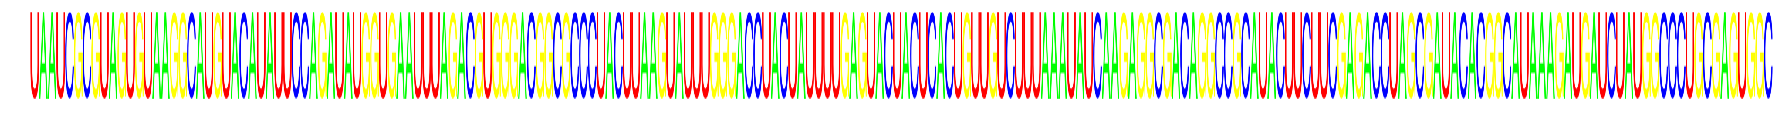

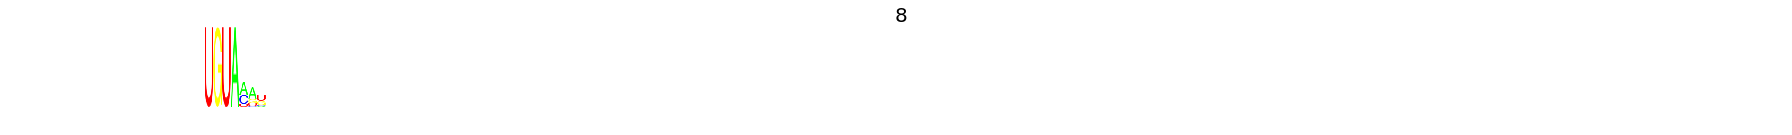

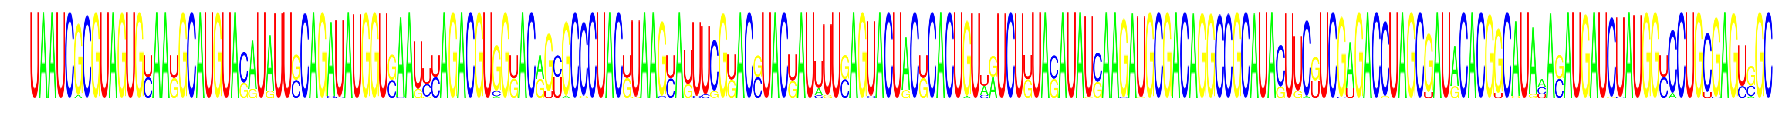

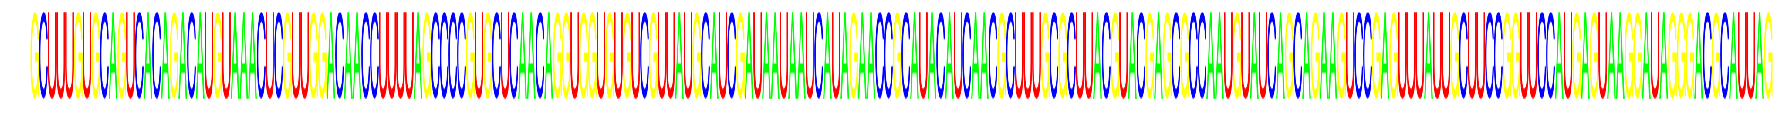

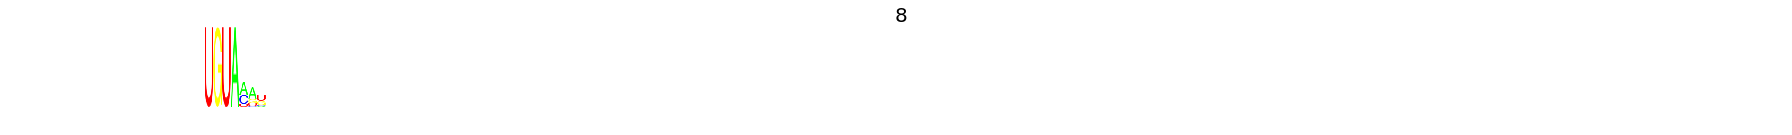

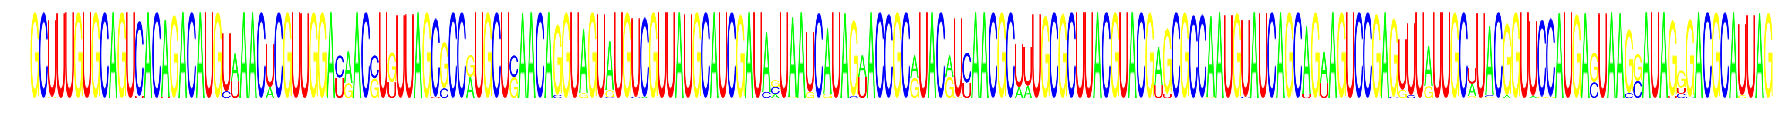

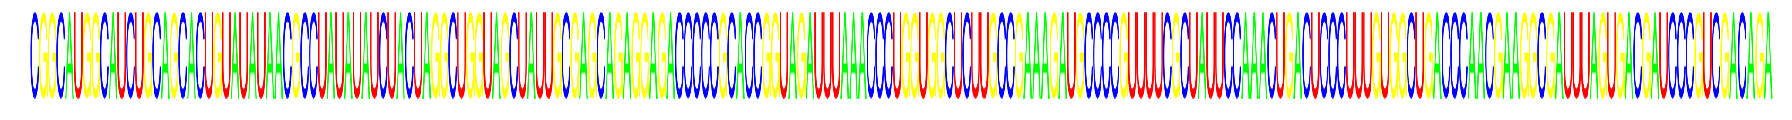

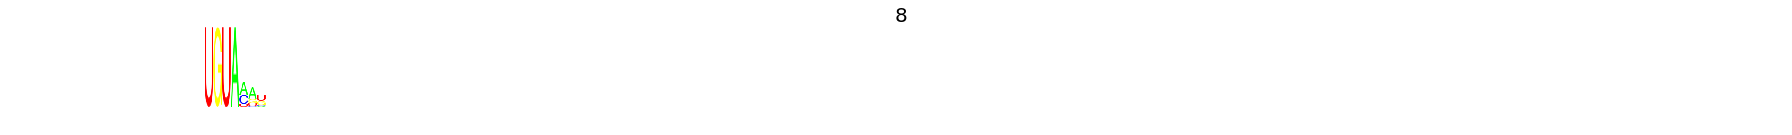

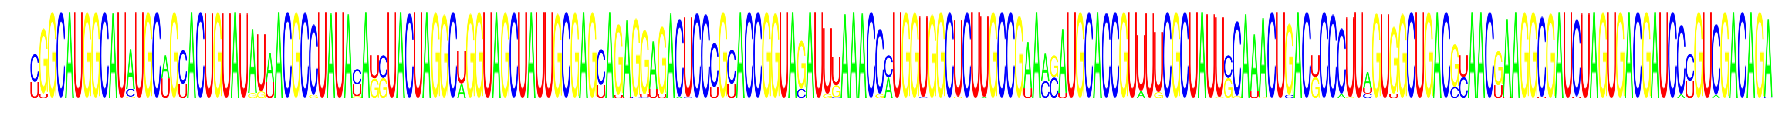

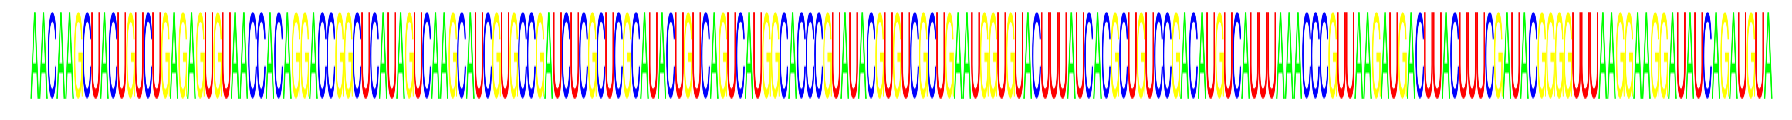

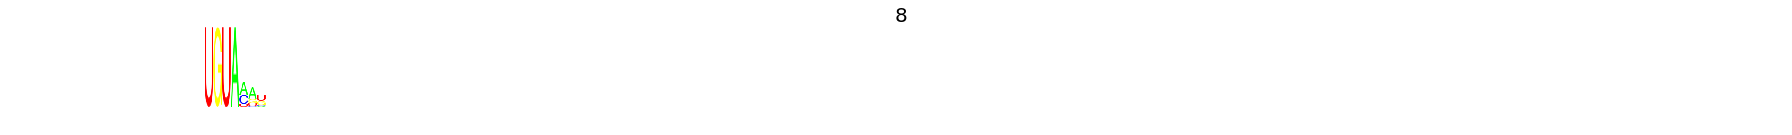

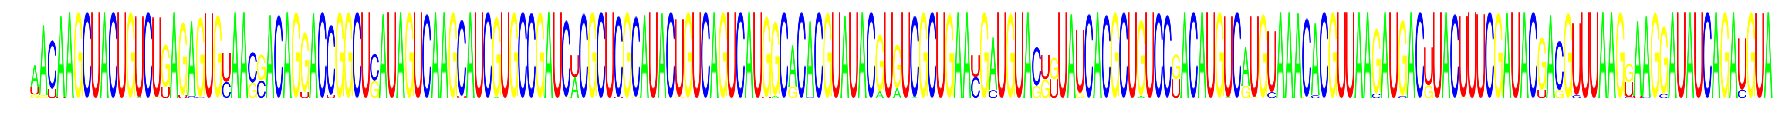

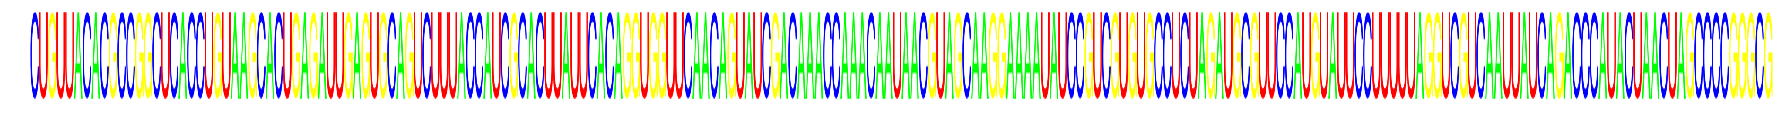

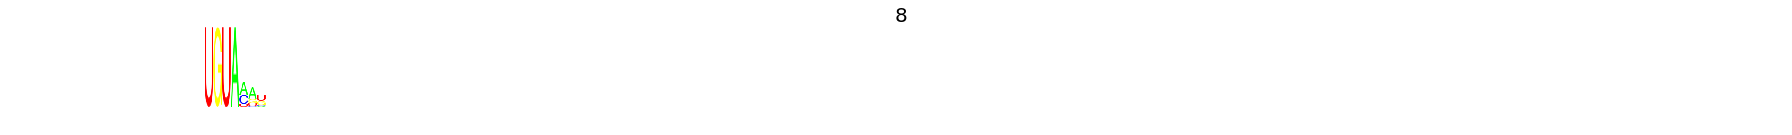

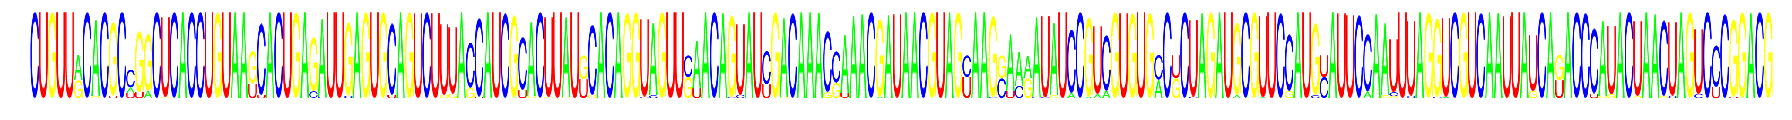

In [16]:
prediction = layers.get_output(deconv['output'], deterministic=False)
test_fun = theano.function([input_var2], prediction)

class_index = 8
labels = np.argmax(test[1],axis=1)
map_index = np.where(labels == class_index)[0]
for index in map_index[:5]:
    
    y = np.expand_dims(test[0][index],0)
    prediction = test_fun(y.astype(np.float32))
    class_index = np.argmax(test[1][index,:])

    height=100
    bp_width=20
    size = (25.,10.0)

    logo = seq_logo(np.squeeze(test[0][index]), height, bp_width, norm=0, rna=1, filepath='.')
    fig = plt.figure(figsize=size);
    plt.imshow(logo, interpolation='none');
    plt.axis('off');

    logo = seq_logo(test[2][index], height, bp_width, norm=0, rna=1, filepath='.')
    fig = plt.figure(figsize=size);
    plt.imshow(logo, interpolation='none');
    plt.axis('off');
    plt.title(str(class_index),fontsize=20)

    pwm =np.squeeze(prediction[0])
    norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
    pwm = pwm/norm
    logo = seq_logo(pwm, height, bp_width, norm=0, rna=1, filepath='.')
    fig = plt.figure(figsize=size);
    plt.imshow(logo, interpolation='none');
    plt.axis('off');


/home/peter/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


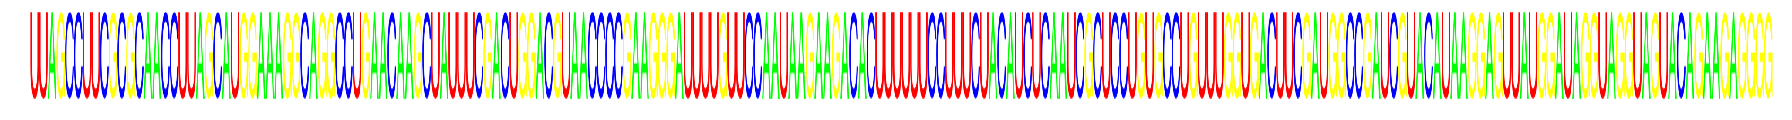

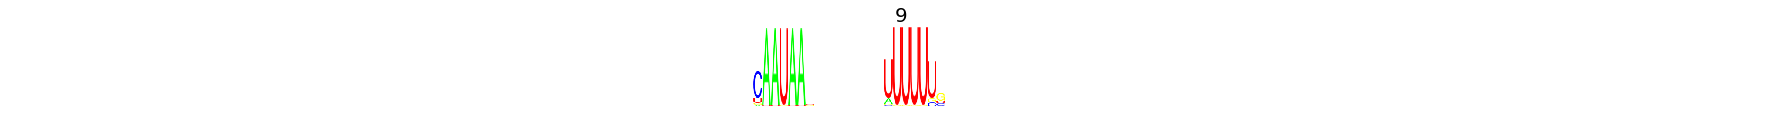

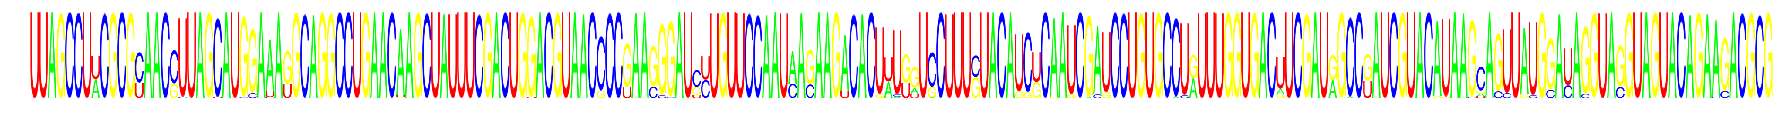

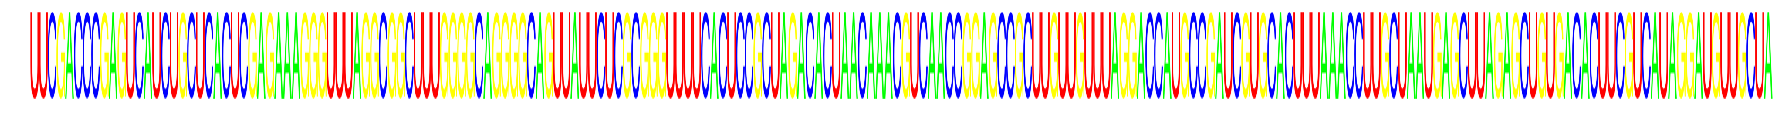

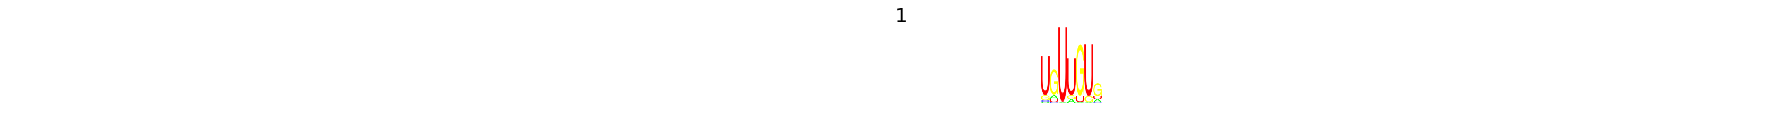

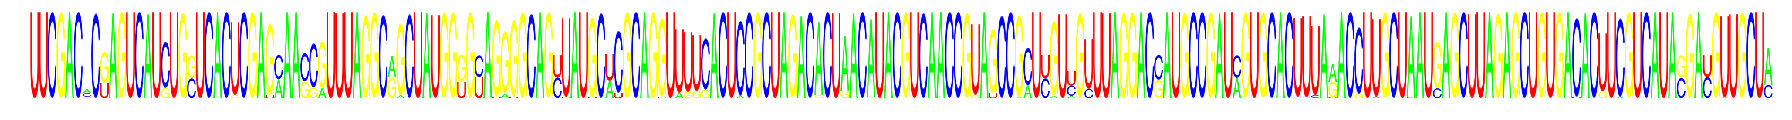

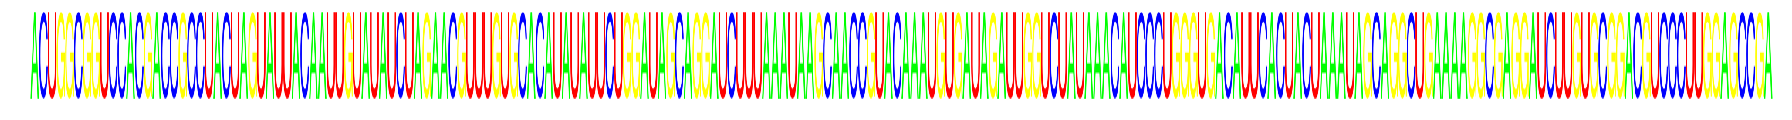

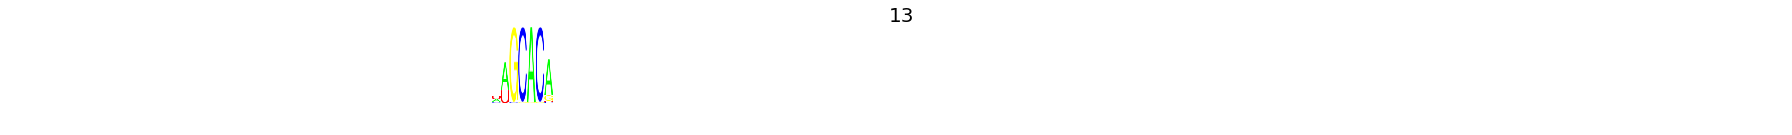

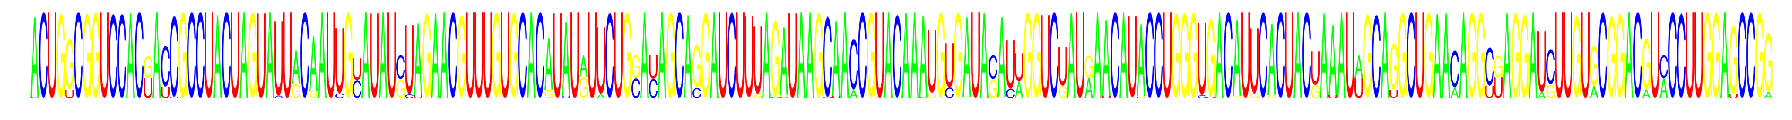

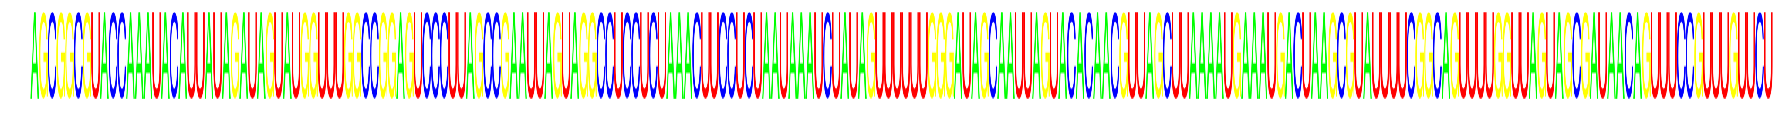

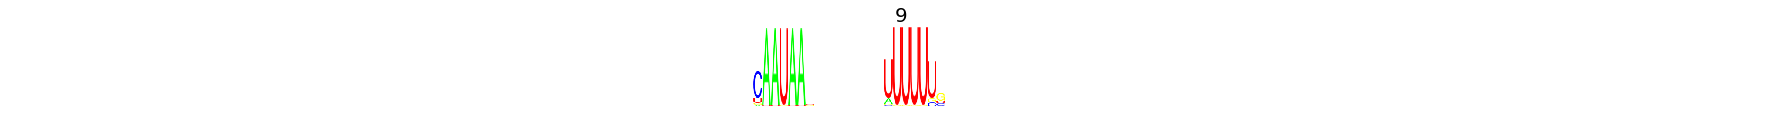

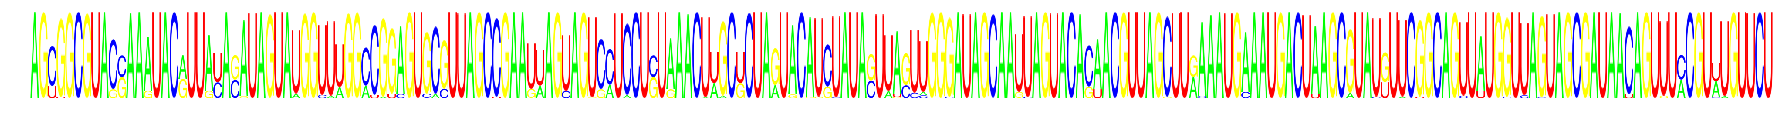

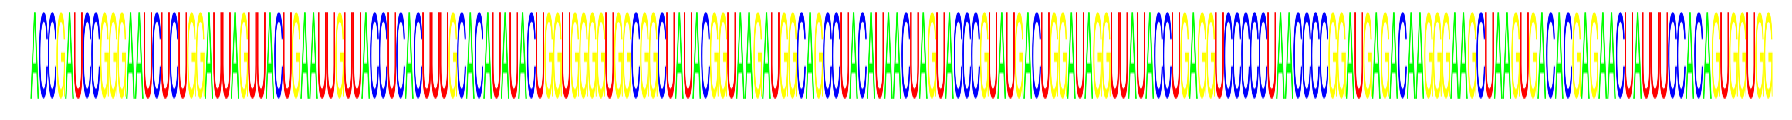

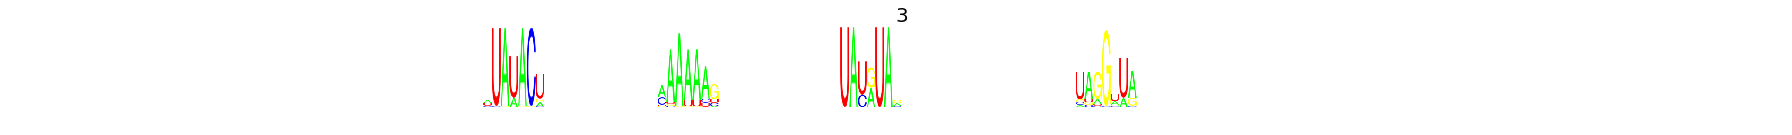

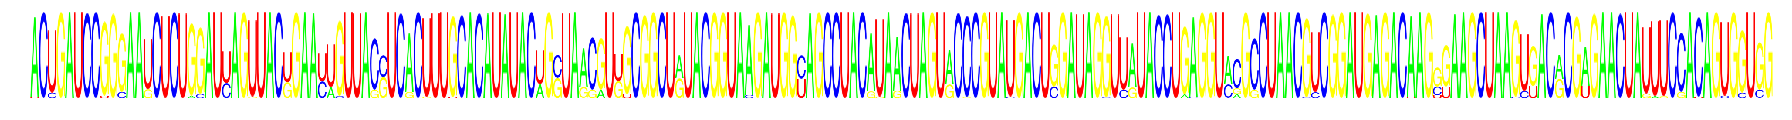

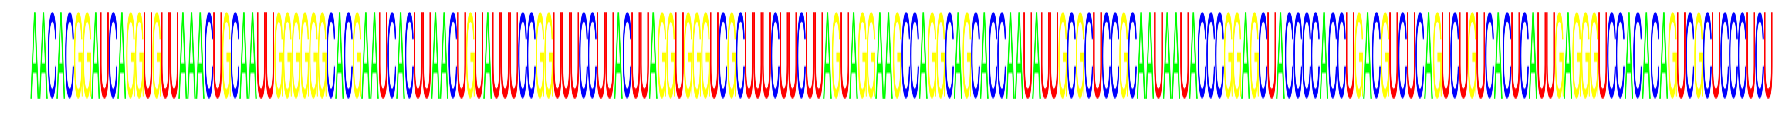

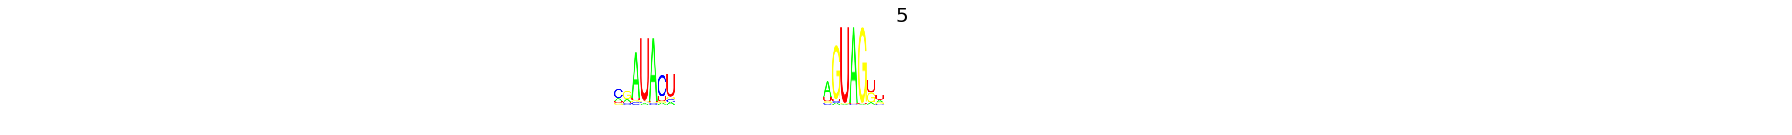

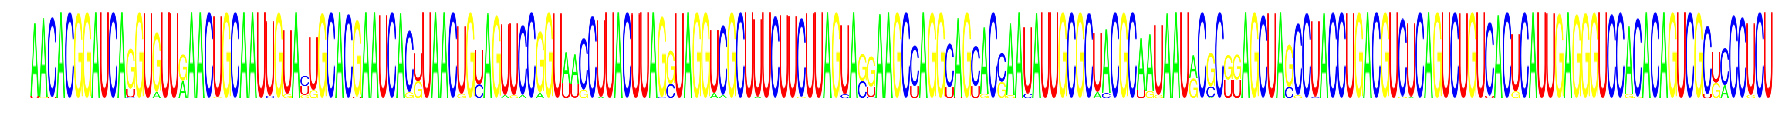

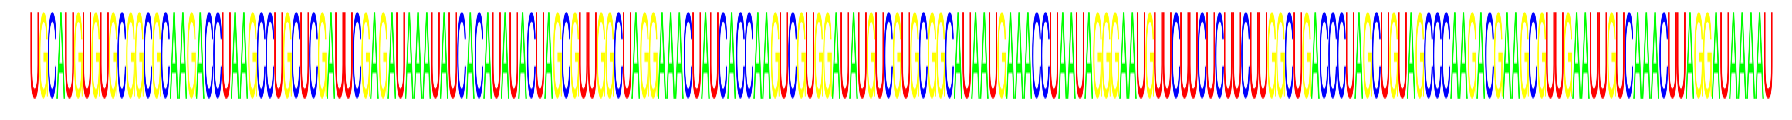

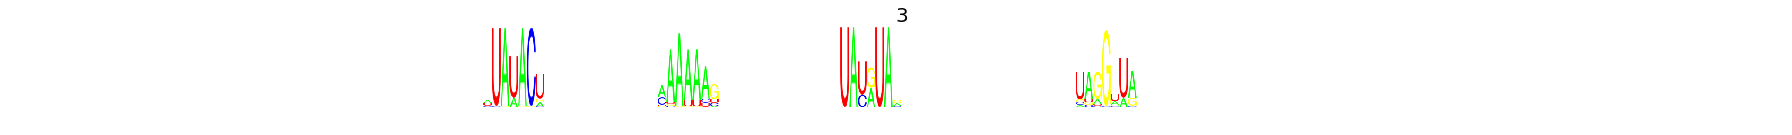

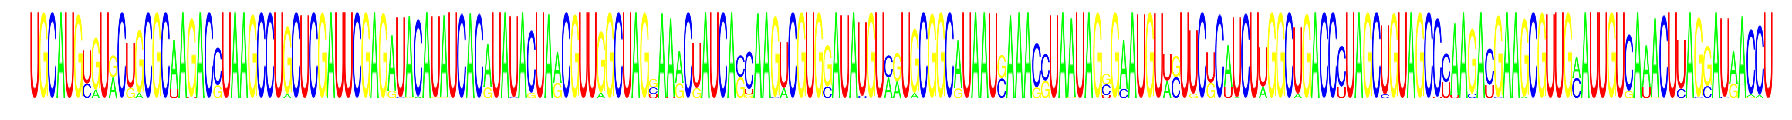

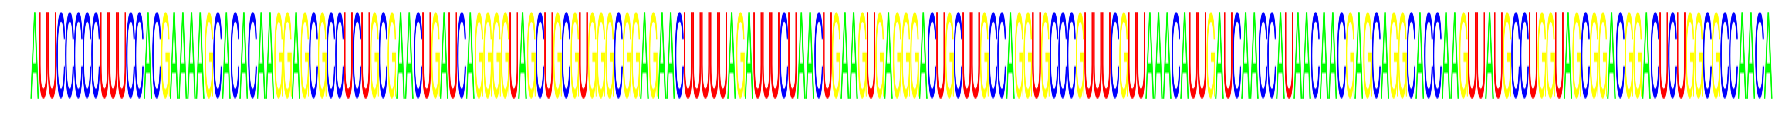

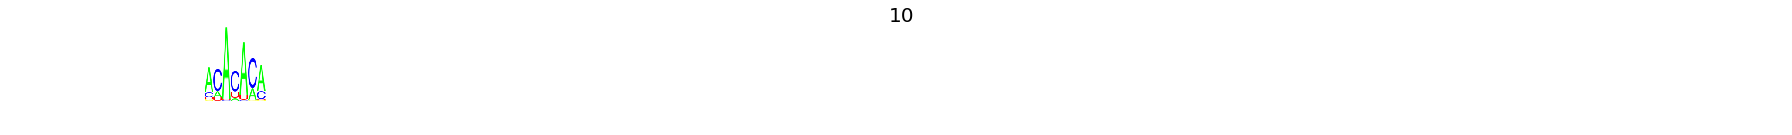

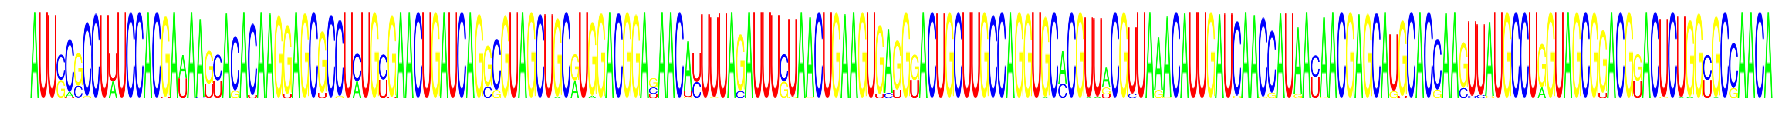

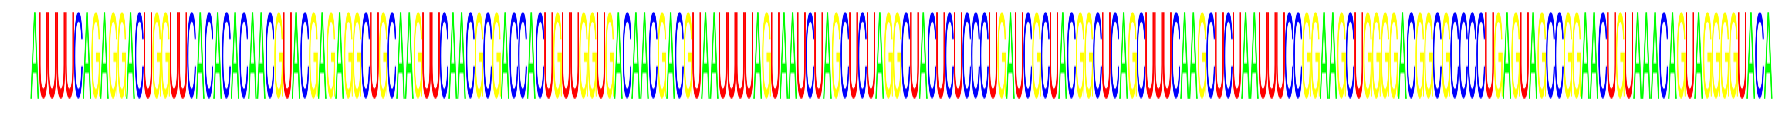

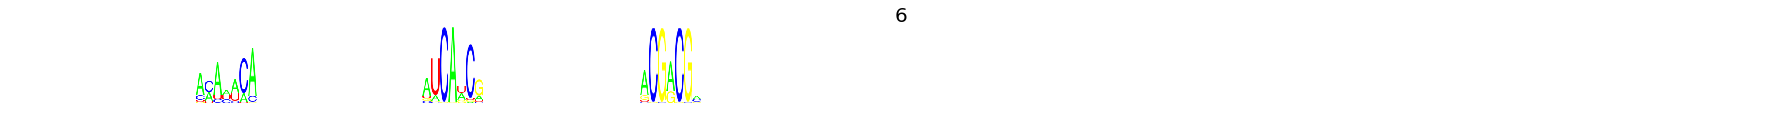

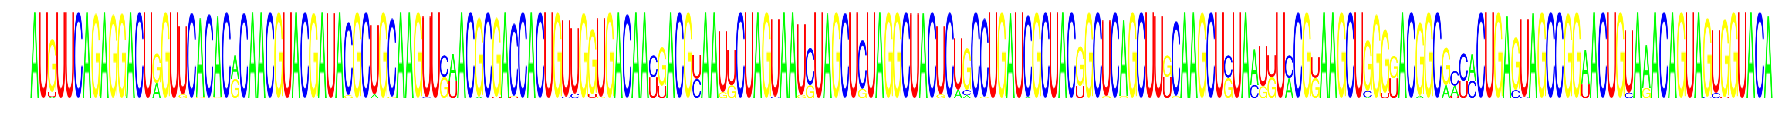

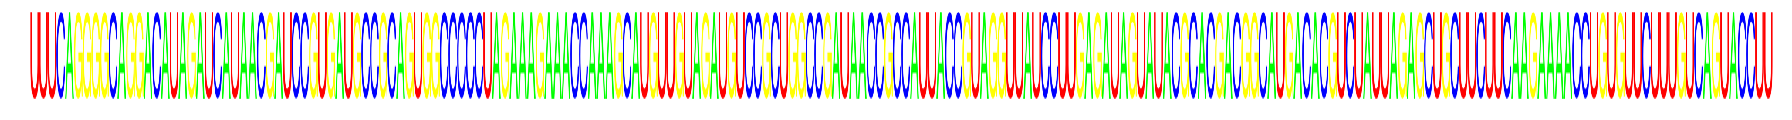

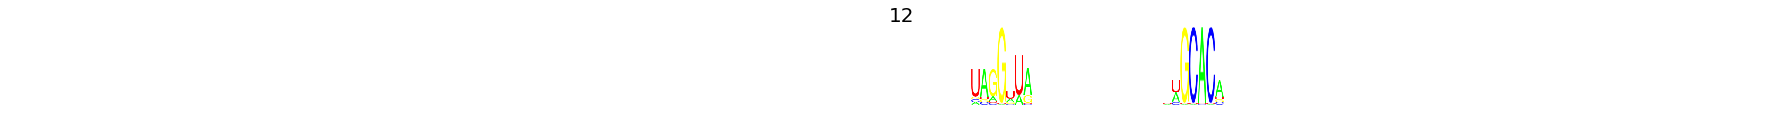

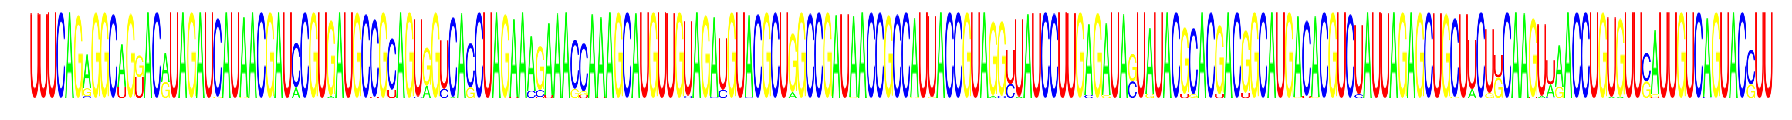

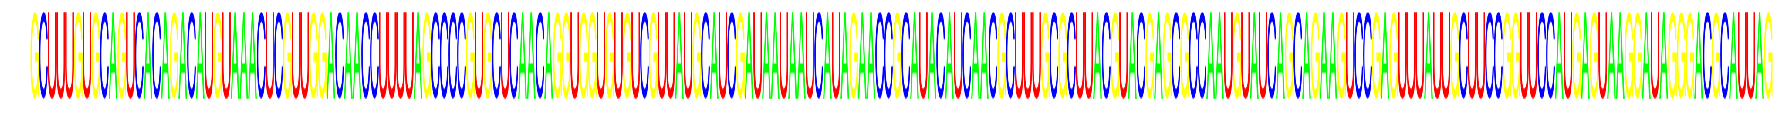

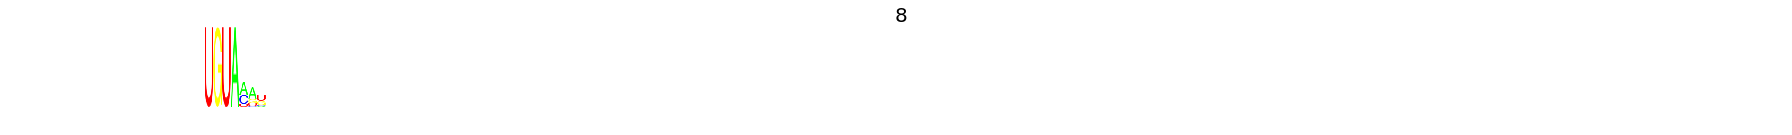

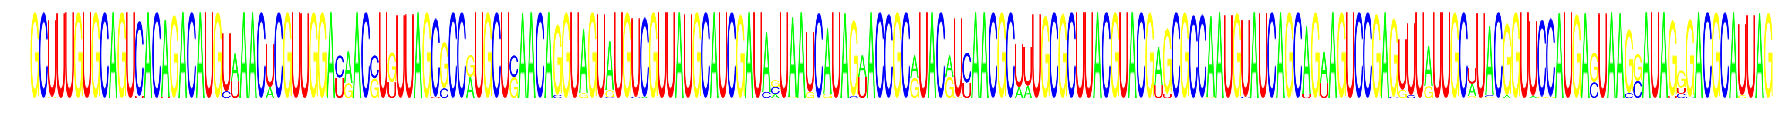

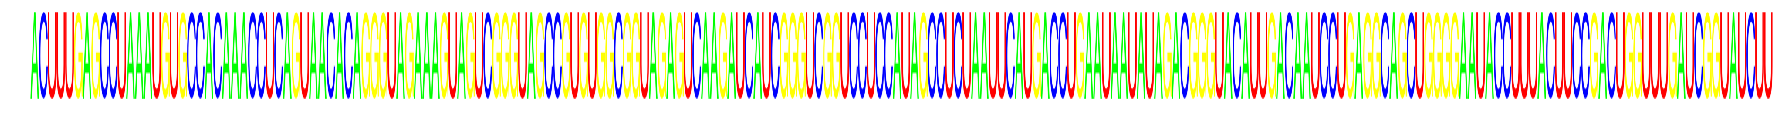

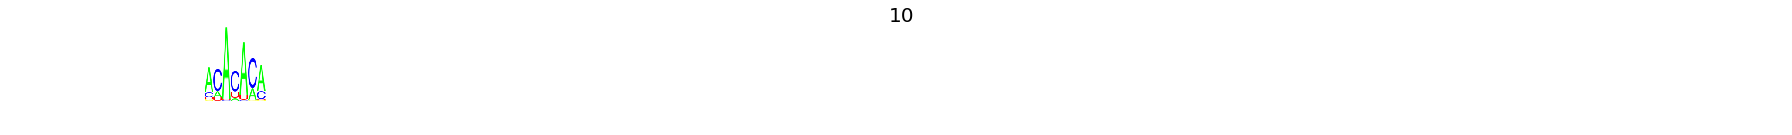

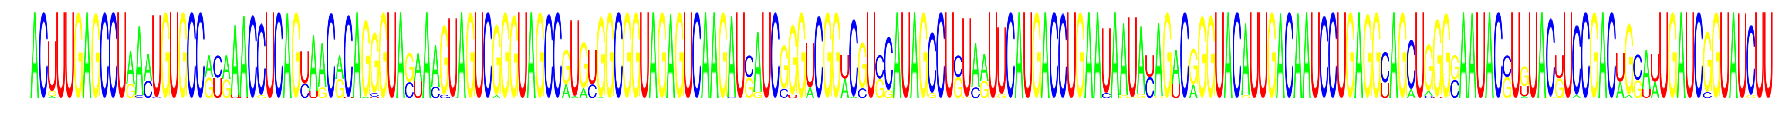

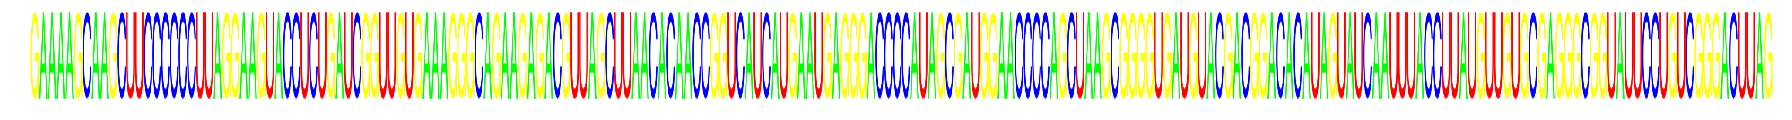

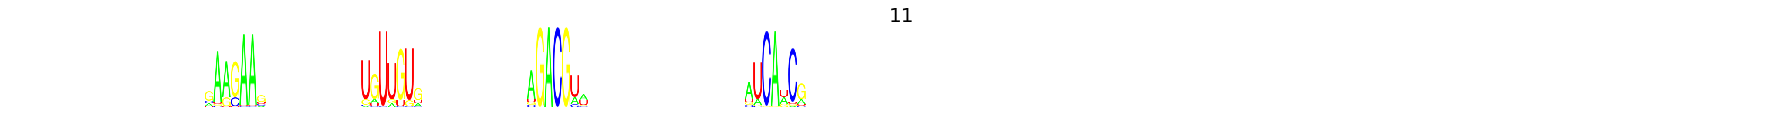

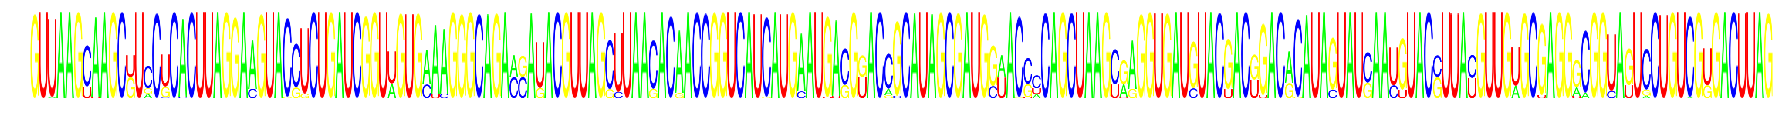

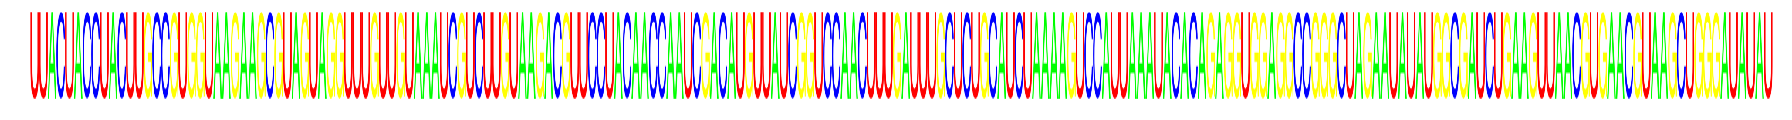

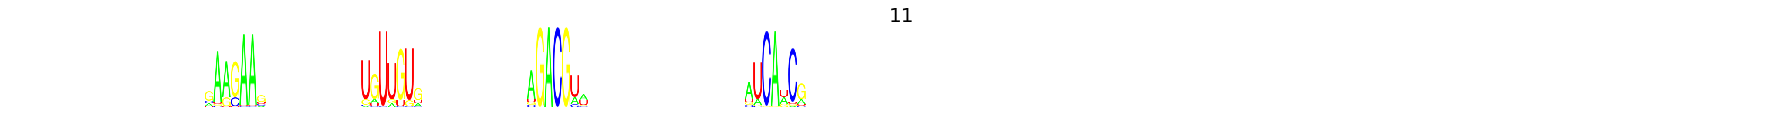

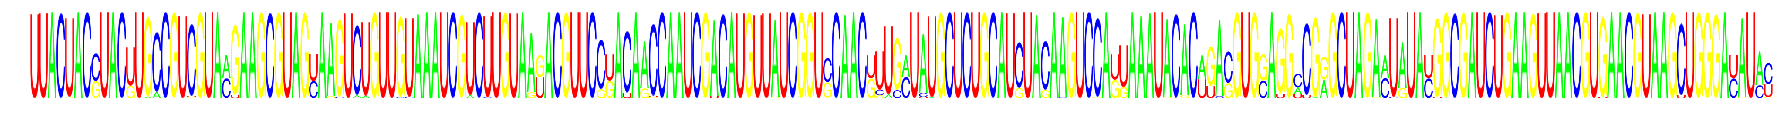

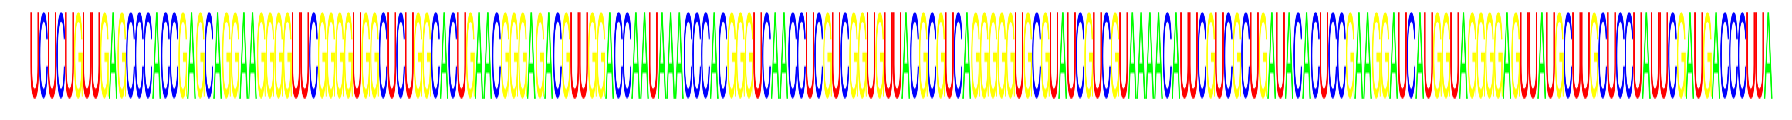

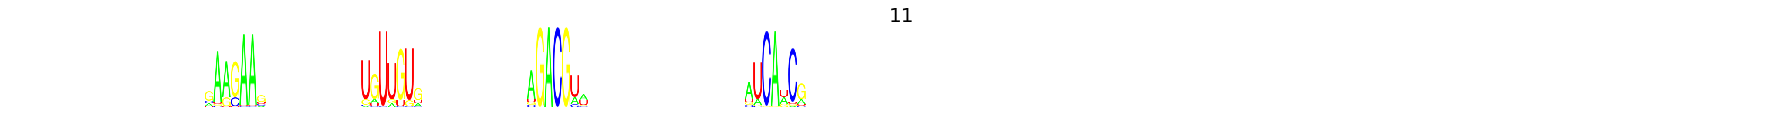

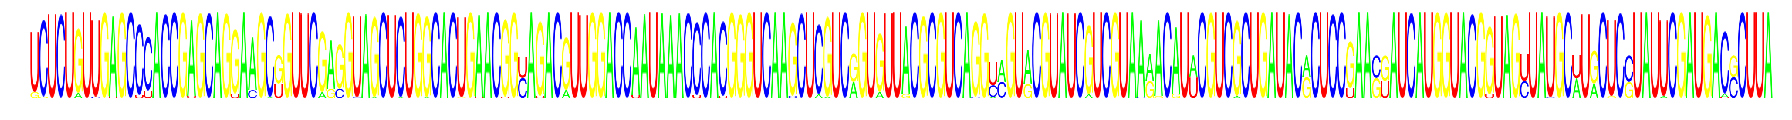

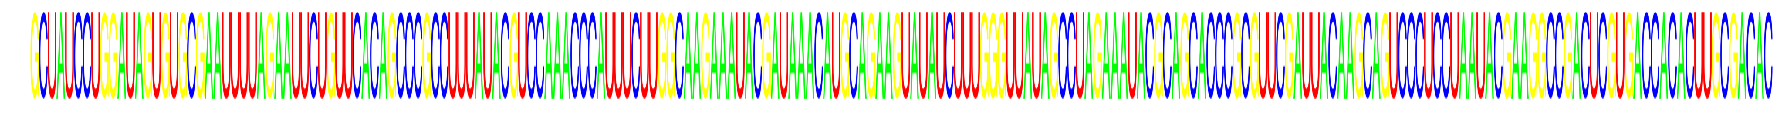

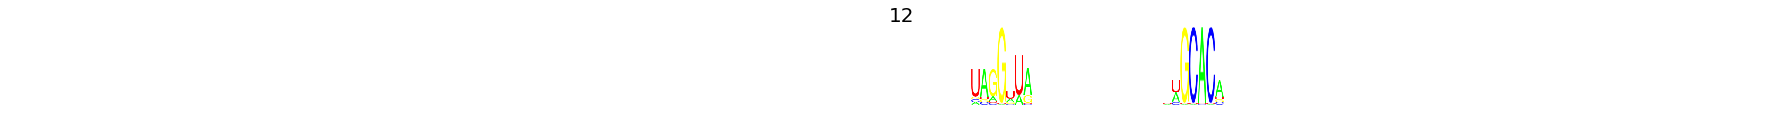

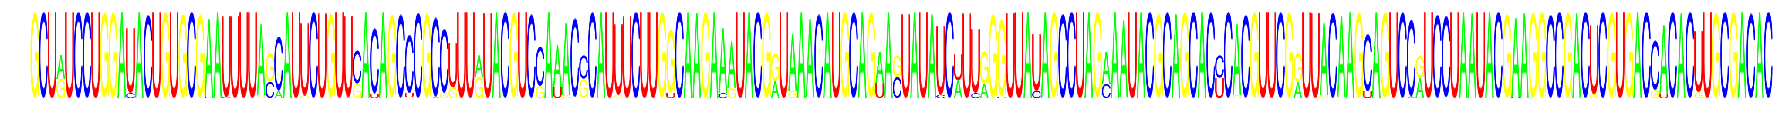

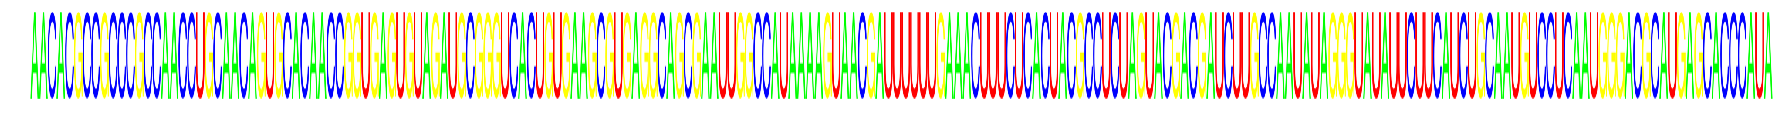

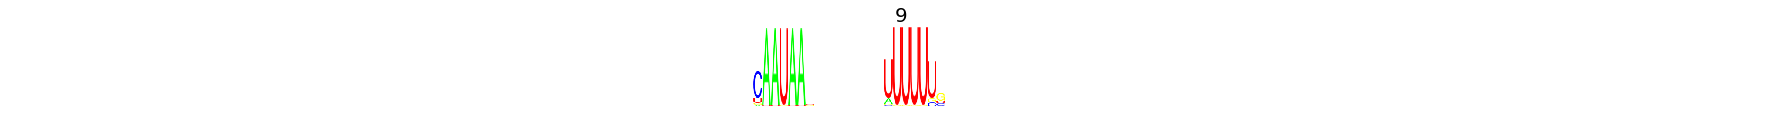

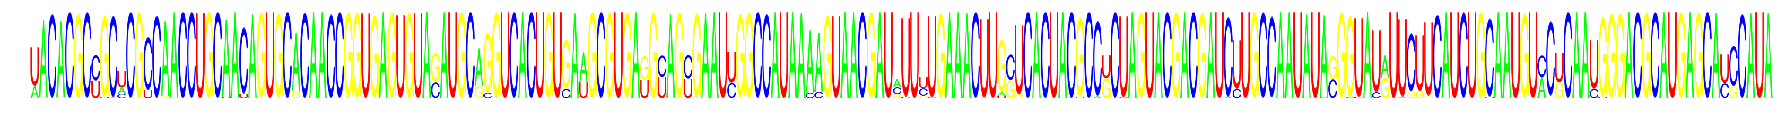

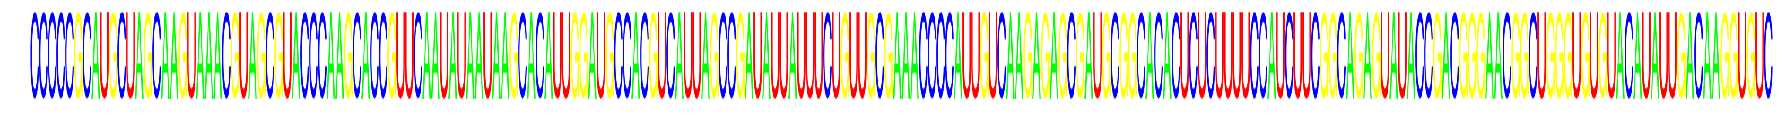

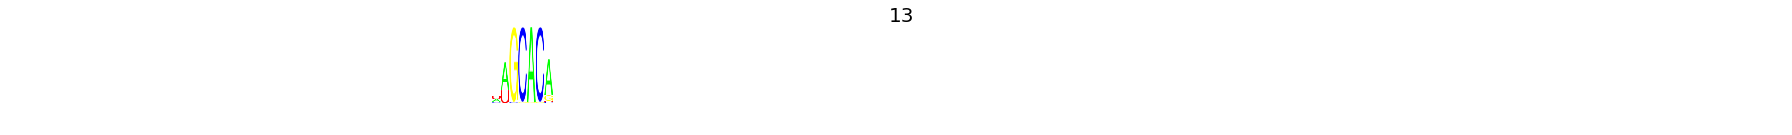

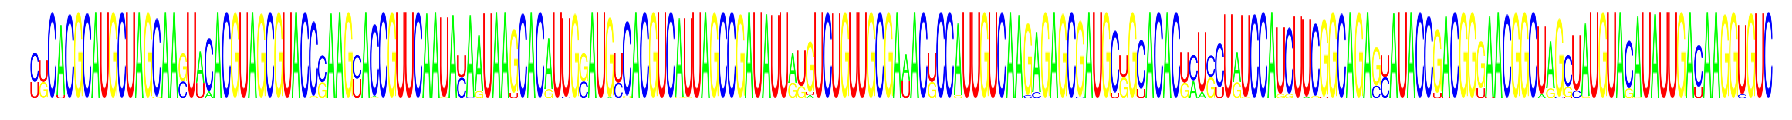

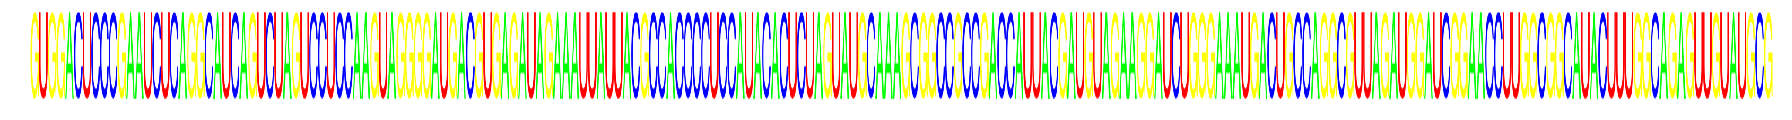

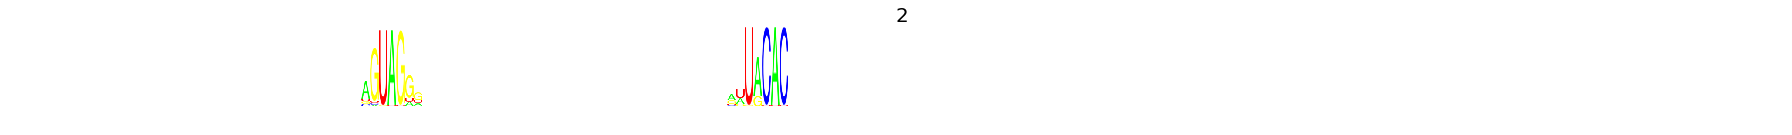

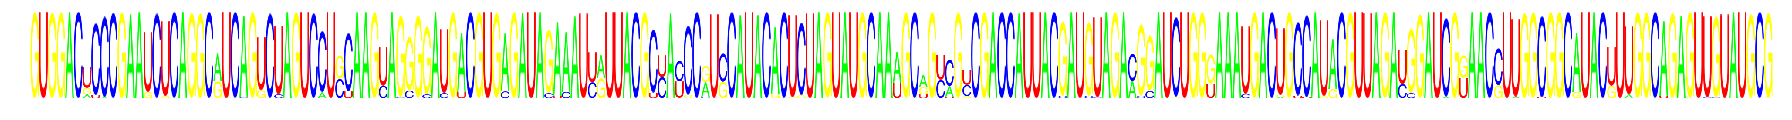

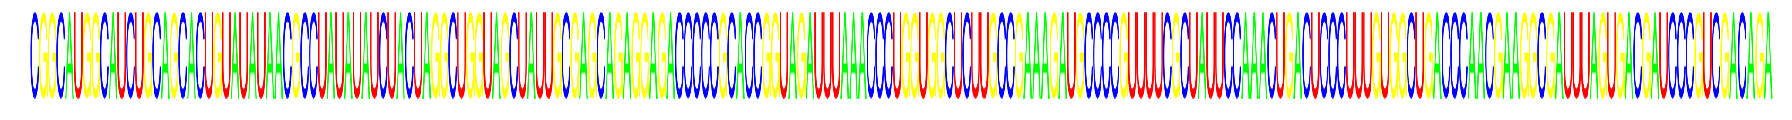

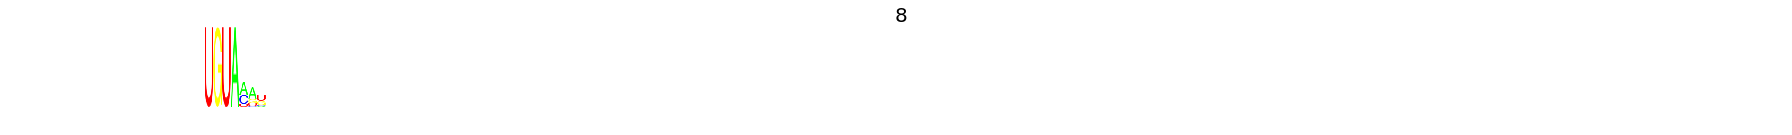

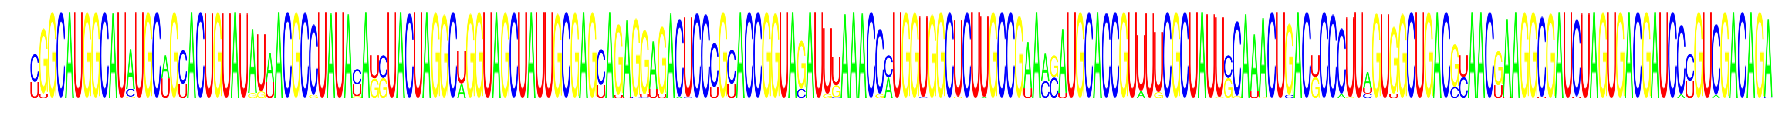

In [17]:
prediction = layers.get_output(deconv['output'], deterministic=False)
test_fun = theano.function([input_var2], prediction)


for index in range(40,60):

    y = np.expand_dims(test[0][index],0)
    prediction = test_fun(y.astype(np.float32))
    class_index = np.argmax(test[1][index,:])

    height=100
    bp_width=20
    size = (25.,10.0)

    logo = seq_logo(np.squeeze(test[0][index]), height, bp_width, norm=0, rna=1, filepath='.')
    fig = plt.figure(figsize=size);
    plt.imshow(logo, interpolation='none');
    plt.axis('off');

    logo = seq_logo(test[2][index], height, bp_width, norm=0, rna=1, filepath='.')
    fig = plt.figure(figsize=size);
    plt.imshow(logo, interpolation='none');
    plt.axis('off');
    plt.title(str(class_index),fontsize=20)
    
    pwm =np.squeeze(prediction[0])
    norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
    pwm = pwm/norm
    logo = seq_logo(pwm, height, bp_width, norm=0, rna=1, filepath='.')
    fig = plt.figure(figsize=size);
    plt.imshow(logo, interpolation='none');
    plt.axis('off');

In [ ]:

prediction = layers.get_output(deconv['output'], deterministic=False)
loss = objectives.squared_error(input_var2, prediction)
loss = objectives.aggregate(loss)
loss = objectives.aggregate(loss, mode='mean')

orig4 = layers.get_output(deconv['conv4_active'], deterministic=False)
recon4 = layers.get_output(deconv['invconv4_pool'], deterministic=False)
loss4 = objectives.squared_error(orig4, recon4)
loss4 = objectives.aggregate(loss4, mode='mean')

orig3 = layers.get_output(deconv['conv3_active'], deterministic=False)
recon3 = layers.get_output(deconv['invconv3_pool'], deterministic=False)
loss3 = objectives.squared_error(orig3, recon3)
loss3 = objectives.aggregate(loss3, mode='mean')

orig2 = layers.get_output(deconv['conv2_active'], deterministic=False)
recon2 = layers.get_output(deconv['invconv2_pool'], deterministic=False)
loss2 = objectives.squared_error(orig2, recon2)
loss2 = objectives.aggregate(loss2, mode='mean')

orig1 = layers.get_output(deconv['conv1_active'], deterministic=False)
recon1 = layers.get_output(deconv['invconv1_pool'], deterministic=False)
loss1 = objectives.squared_error(orig1, recon1)
loss1 = objectives.aggregate(loss1, mode='mean')

loss = loss + loss4 + loss3 + loss2 + loss1

params = layers.get_all_params(deconv['output'], trainable=True)    
grad = T.grad(loss, params)

update_op = updates.adam(grad, params, learning_rate=0.001)
train_fun = theano.function([input_var2], loss, updates=update_op, allow_input_downcast=True)

In [ ]:

def batch_generator2(X, batch_size=128):
    for start_idx in range(0, len(X)-batch_size+1, batch_size):
        excerpt = slice(start_idx, start_idx+batch_size)
        yield X[excerpt].astype(np.float32)

batch_size = 128        
for epoch in range(20):
    sys.stdout.write("\rEpoch %d \n"%(epoch+1))

    num_batches = train[0].shape[0] // batch_size
    batches = batch_generator2(train[0], batch_size)
    value = 0
    for i in range(num_batches):
        X = next(batches)
        loss = train_fun(X)
        value += np.mean(loss)
    sys.stdout.write("\r  loss = %f \n"%(value/num_batches))

In [ ]:
input_var3 = T.tensor4()
recon = {}
recon['input'] = InputLayer(tuple(shape), input_var=input_var3)
recon['conv1']  = Conv2DLayer(recon['input'], num_filters=32,
                                          filter_size=(11,1),
                                          W=network['conv1'].W,
                                          b=None, 
                                          pad='same',
                                          nonlinearity=None, flip_filters=False)
recon['conv1_bias'] = BiasLayer(recon['conv1'], b=network['conv1_bias'].b)
recon['conv1_norm'] = BatchNormLayer(recon['conv1_bias'], beta=network['conv1_batch'].beta, 
                                                            gamma=network['conv1_batch'].gamma, 
                                                            mean=network['conv1_batch'].mean, 
                                                            inv_std=network['conv1_batch'].inv_std)

recon['conv1_active'] = NonlinearityLayer(recon['conv1_norm'], nonlinearity=nonlinearities.rectify)
recon['conv1_pool'] = MaxPool2DLayer(recon['conv1_active'], pool_size=(5,1))


recon['conv2']  = Conv2DLayer(recon['conv1_pool'], num_filters=64,
                                          filter_size=(7,1),
                                          W=network['conv2'].W,
                                          b=None, 
                                          pad='same',
                                          nonlinearity=nonlinearities.rectify, flip_filters=False)
recon['conv2_bias'] = BiasLayer(recon['conv2'], b=network['conv2_bias'].b)
recon['conv2_norm'] = BatchNormLayer(recon['conv2_bias'], beta=network['conv2_batch'].beta, 
                                                            gamma=network['conv2_batch'].gamma, 
                                                            mean=network['conv2_batch'].mean, 
                                                            inv_std=network['conv2_batch'].inv_std)
recon['conv2_active'] = NonlinearityLayer(recon['conv2_norm'], nonlinearity=nonlinearities.rectify)
recon['conv2_pool'] = MaxPool2DLayer(recon['conv2_active'], pool_size=(2,1))

recon['conv3']  = Conv2DLayer(recon['conv2_pool'], num_filters=128,
                                          filter_size=(5,1),
                                          W=network['conv3'].W,
                                          b=None, 
                                          pad='same',
                                          nonlinearity=None, flip_filters=False)
recon['conv3_bias'] = BiasLayer(recon['conv3'], b=network['conv3_bias'].b)
recon['conv3_norm'] = BatchNormLayer(recon['conv3_bias'], beta=network['conv3_batch'].beta, 
                                                            gamma=network['conv3_batch'].gamma, 
                                                            mean=network['conv3_batch'].mean, 
                                                            inv_std=network['conv3_batch'].inv_std)
recon['conv3_active'] = NonlinearityLayer(recon['conv3_norm'], nonlinearity=nonlinearities.rectify)
recon['conv3_pool'] = MaxPool2DLayer(recon['conv3_active'], pool_size=(2,1))

recon['conv4']  = Conv2DLayer(recon['conv3_pool'], num_filters=256,
                                          filter_size=(5,1),
                                          W=network['conv4'].W,
                                          b=None, 
                                          pad='same',
                                          nonlinearity=None, flip_filters=False)
recon['conv4_bias'] = BiasLayer(recon['conv4'], b=network['conv4_bias'].b)
recon['conv4_norm'] = BatchNormLayer(recon['conv4_bias'], beta=network['conv4_batch'].beta, 
                                                            gamma=network['conv4_batch'].gamma, 
                                                            mean=network['conv4_batch'].mean, 
                                                            inv_std=network['conv4_batch'].inv_std)
recon['conv4_active'] = NonlinearityLayer(recon['conv4_norm'], nonlinearity=nonlinearities.rectify)
recon['conv4_pool'] = MaxPool2DLayer(recon['conv4_active'], pool_size=(2,1))



recon['dense1'] = DenseLayer(recon['conv4_pool'], num_units=512, W=network['dense1'].W, 
                                     b=None, nonlinearity=None)
recon['dense1_bias'] = BiasLayer(recon['dense1'], b=network['dense1_bias'].b)
recon['dense1_norm'] = BatchNormLayer(recon['dense1_bias'], beta=network['dense1_batch'].beta, 
                                                            gamma=network['dense1_batch'].gamma, 
                                                            mean=network['dense1_batch'].mean, 
                                                            inv_std=network['dense1_batch'].inv_std)
recon['dense1_active'] = NonlinearityLayer(recon['dense1_norm'], nonlinearity=nonlinearities.rectify)
recon['dense1'].params[recon['dense1'].W].remove('trainable')
recon['dense1_bias'].params[recon['dense1_bias'].b].remove('trainable')
recon['dense1_norm'].params[recon['dense1_norm'].beta].remove('trainable')
recon['dense1_norm'].params[recon['dense1_norm'].gamma].remove('trainable')

recon['dense2'] = DenseLayer(recon['dense1_active'], num_units=20, W=network['dense2'].W, 
                                     b=None, nonlinearity=None)
recon['dense2_bias'] = BiasLayer(recon['dense2'], b=network['dense2_bias'].b)
recon['dense2_active'] = NonlinearityLayer(recon['dense2_bias'], nonlinearity=nonlinearities.sigmoid)

recon['encode'] = NonlinearityLayer(recon['dense2_active'], nonlinearity=None)

num_units = list(get_output_shape(network['dense1']))[1]
recon['invdense3'] = DenseLayer(recon['encode'], num_units=num_units, W=network['dense2'].W.dimshuffle([1,0]), 
                                     b=init.Constant(0.05), nonlinearity=None)
recon['invdense3_scale'] = ExpressionLayer(recon['invdense3'], lambda X: X-0.1, output_shape='auto')
recon['invdense3_active'] = NonlinearityLayer(recon['invdense3_scale'], nonlinearity=nonlinearities.rectify)

num_units = np.prod(list(get_output_shape(network['conv4_pool']))[1:])
recon['invdense1'] = DenseLayer(recon['invdense3_active'], num_units=num_units, W=network['dense1'].W.dimshuffle([1,0]), 
                                     b=init.Constant(0.05), nonlinearity=None)
recon['invdense1_scale'] = ExpressionLayer(recon['invdense1'], lambda X: X-.055, output_shape='auto')
recon['invdense1_active'] = NonlinearityLayer(recon['invdense1_scale'], nonlinearity=nonlinearities.rectify)

shape2 = list(get_output_shape(recon['conv4_pool']))
shape2[0] = -1
recon['reshape'] = layers.ReshapeLayer(recon['invdense1_active'], shape=tuple(shape2))

recon['invconv4_pool'] = InverseLayer(recon['reshape'], recon['conv4_pool'])
recon['invconv4']  = Conv2DLayer(recon['invconv4_pool'], num_filters=network['conv4'].input_shape[1],
                                          filter_size=network['conv4'].filter_size,
                                          W=network['conv4'].W.dimshuffle([1,0,2,3]), #W2_inv, #
                                          b=deconv['invconv4'].b, 
                                          pad='same',
                                          nonlinearity=None, flip_filters=True)
recon['invconv4_scale'] = ExpressionLayer(recon['invconv4'], lambda X: X-.0, output_shape='auto')
recon['invconv4_active'] = NonlinearityLayer(recon['invconv4_scale'], nonlinearity=nonlinearities.rectify)

recon['invconv3_pool'] = InverseLayer(recon['invconv4_active'], recon['conv3_pool'])
recon['invconv3']  = Conv2DLayer(recon['invconv3_pool'], num_filters=network['conv3'].input_shape[1],
                                          filter_size=network['conv3'].filter_size,
                                          W=network['conv3'].W.dimshuffle([1,0,2,3]), #W2_inv, #
                                          b=deconv['invconv3'].b, 
                                          pad='same',
                                          nonlinearity=None, flip_filters=True)
recon['invconv3_scale'] = ExpressionLayer(recon['invconv3'], lambda X: X-.0, output_shape='auto')
recon['invconv3_active'] = NonlinearityLayer(recon['invconv3_scale'], nonlinearity=nonlinearities.rectify)

recon['invconv2_pool'] = InverseLayer(recon['invconv3_active'], recon['conv2_pool'])
recon['invconv2']  = Conv2DLayer(recon['invconv2_pool'], num_filters=network['conv2'].input_shape[1],
                                          filter_size=network['conv2'].filter_size,
                                          W=network['conv2'].W.dimshuffle([1,0,2,3]), #W2_inv, #
                                          b=deconv['invconv2'].b, 
                                          pad='same',
                                          nonlinearity=None, flip_filters=True)
recon['invconv2_scale'] = ExpressionLayer(recon['invconv2'], lambda X: X-.0, output_shape='auto')
recon['invconv2_active'] = NonlinearityLayer(recon['invconv2_scale'], nonlinearity=nonlinearities.rectify)

recon['invconv1_pool'] = InverseLayer(recon['invconv2_active'], recon['conv1_pool'])
recon['invconv1']  = Conv2DLayer(recon['invconv1_pool'], num_filters=network['conv1'].input_shape[1],
                                          filter_size=network['conv1'].filter_size,
                                          W=network['conv1'].W.dimshuffle([1,0,2,3]), #W2_inv, #
                                          b=init.Constant(0), #deconv['invconv1'].b, 
                                          pad='same',
                                          nonlinearity=nonlinearities.sigmoid, flip_filters=True)
recon['invconv1_scale'] = ExpressionLayer(recon['invconv1'], lambda X: X-.0, output_shape='auto')
recon['invconv1_active'] = NonlinearityLayer(recon['invconv1_scale'], nonlinearity=nonlinearities.rectify)
recon['output'] = recon['invconv1_active']


In [ ]:
generated_x = get_output(recon['output'], deterministic=True)
gen_fn = theano.function([input_var3], generated_x)

In [ ]:
index=520
seq = test[0][index]
gen = gen_fn(np.expand_dims(seq,0))

In [ ]:
pwm =np.squeeze(seq)
norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
pwm = pwm/norm
logo = seq_logo(pwm, height, bp_width, norm=0, rna=1, filepath='.')
fig = plt.figure(figsize=size);
plt.imshow(logo, interpolation='none');
plt.axis('off');

pwm =np.squeeze(gen[0])
norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
pwm = pwm/norm
logo = seq_logo(pwm, height, bp_width, norm=0, rna=1, filepath='.')
fig = plt.figure(figsize=size);
plt.imshow(logo, interpolation='none');
plt.axis('off');

In [ ]:
z = get_output(recon['invdense1'], deterministic=True)
test_fun = theano.function([input_var3], z)

val = test_fun(np.expand_dims(test[0][index],0))
val = np.squeeze(val[0])

z = get_output(recon['invdense1_scale'], deterministic=True)
test_fun = theano.function([input_var3], z)
val2 = test_fun(np.expand_dims(test[0][index],0))
val2 = np.squeeze(val2[0])

z = get_output(recon['invdense1_active'], deterministic=True)
test_fun = theano.function([input_var3], z)
val3 = test_fun(np.expand_dims(test[0][index],0))
val3 = np.squeeze(val3[0])

plt.figure()
plt.plot(val);

plt.figure()
plt.plot(val2);

plt.figure()
plt.plot(val3);

In [ ]:
z = get_output(recon['invdense3'], deterministic=True)
test_fun = theano.function([input_var3], z)

val = test_fun(np.expand_dims(test[0][index],0))
val = np.squeeze(val[0])

z = get_output(recon['invdense3_scale'], deterministic=True)
test_fun = theano.function([input_var3], z)
val2 = test_fun(np.expand_dims(test[0][index],0))
val2 = np.squeeze(val2[0])

z = get_output(recon['invdense3_active'], deterministic=True)
test_fun = theano.function([input_var3], z)
val3 = test_fun(np.expand_dims(test[0][index],0))
val3 = np.squeeze(val3[0])

plt.figure()
plt.plot(val);

plt.figure()
plt.plot(val2);

plt.figure()
plt.plot(val3);

In [ ]:
prediction = layers.get_output(deconv['output'], deterministic=False)
test_fun = theano.function([input_var2], prediction)

for index in range(5):
    
    y = np.expand_dims(test[0][index],0)
    prediction = test_fun(y.astype(np.float32))
    class_index = np.argmax(test[1][index,:])

    height=100
    bp_width=20
    size = (25.,10.0)

    logo = seq_logo(np.squeeze(test[0][index]), height, bp_width, norm=0, rna=1, filepath='.')
    fig = plt.figure(figsize=size);
    plt.imshow(logo, interpolation='none');
    plt.axis('off');

    pwm =np.squeeze(prediction[0])
    norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
    pwm = pwm/norm
    logo = seq_logo(pwm, height, bp_width, norm=0, rna=1, filepath='.')
    fig = plt.figure(figsize=size);
    plt.imshow(logo, interpolation='none');
    plt.axis('off');


In [ ]:
"""
num_units = list(get_output_shape(network['dense2']))[1]
deconv['dense3'] = layers.DenseLayer(deconv['input'], num_units=num_units, W=network['dense3'].W.dimshuffle([1,0]), 
                                     b=init.Constant(0.05), nonlinearity=nonlinearities.rectify)
num_units = np.prod(list(get_output_shape(network['dense1']))[1:])
deconv['dense2'] = layers.DenseLayer(deconv['dense3'], num_units=num_units, W=network['dense2'].W.dimshuffle([1,0]), 
                                     b=init.Constant(0.05), nonlinearity=nonlinearities.rectify)
num_units = np.prod(list(get_output_shape(network['conv7_pool']))[1:])
deconv['dense1'] = layers.DenseLayer(deconv['dense2'], num_units=num_units, W=network['dense1'].W.dimshuffle([1,0]), 
                                     b=init.Constant(0.05), nonlinearity=nonlinearities.rectify)

shape = list(get_output_shape(network['conv7_pool']))
shape[0] = -1
deconv['reshape'] = layers.ReshapeLayer(deconv['dense1'], shape=tuple(shape))
deconv['pool7'] = layers.Upscale2DLayer(deconv['reshape'], (5,1))
deconv['conv7']  = Conv2DLayer(deconv['pool7'], num_filters=network['conv7'].input_shape[1],
                                          filter_size=network['conv7'].filter_size,
                                          W=network['conv7'].W.dimshuffle([1,0,2,3]), #W2_inv, #
                                          b=init.Constant(0.05), 
                                          pad='same',
                                          nonlinearity=nonlinearities.rectify, flip_filters=True)

deconv['pool6'] = layers.Upscale2DLayer(deconv['conv7'], (2,1))
deconv['conv6']  = Conv2DLayer(deconv['pool6'], num_filters=network['conv6'].input_shape[1],
                                          filter_size=network['conv6'].filter_size,
                                          W=network['conv6'].W.dimshuffle([1,0,2,3]), #W2_inv, #
                                          b=init.Constant(0.05), 
                                          pad='same',
                                          nonlinearity=nonlinearities.rectify, flip_filters=True)

deconv['conv5']  = Conv2DLayer(deconv['conv6'], num_filters=network['conv5'].input_shape[1],
                                         filter_size=network['conv5'].filter_size,
                                          W=network['conv5'].W.dimshuffle([1,0,2,3]), #W2_inv, #
                                          b=init.Constant(0.05), 
                                          pad='same',
                                          nonlinearity=nonlinearities.rectify, flip_filters=True)

deconv['pool4'] = layers.Upscale2DLayer(deconv['conv5'], (2,1))
deconv['conv4']  = Conv2DLayer(deconv['pool4'], num_filters=network['conv4'].input_shape[1],
                                          filter_size=network['conv4'].filter_size,
                                          W=network['conv4'].W.dimshuffle([1,0,2,3]), #W2_inv, #
                                          b=init.Constant(0.05), 
                                          pad='same',
                                          nonlinearity=nonlinearities.rectify, flip_filters=True)

deconv['conv3']  = Conv2DLayer(deconv['conv4'], num_filters=network['conv3'].input_shape[1],
                                          filter_size=network['conv3'].filter_size,
                                          W=network['conv3'].W.dimshuffle([1,0,2,3]), #W2_inv, #
                                          b=init.Constant(0.05), 
                                          pad='same',
                                          nonlinearity=nonlinearities.rectify, flip_filters=True)

deconv['pool2'] = layers.Upscale2DLayer(deconv['conv3'], (2,1))
deconv['conv2']  = Conv2DLayer(deconv['pool2'], num_filters=network['conv2'].input_shape[1],
                                          filter_size=network['conv2'].filter_size,
                                          W=network['conv2'].W.dimshuffle([1,0,2,3]), #W2_inv, #
                                          b=init.Constant(0.05), 
                                          pad='same',
                                          nonlinearity=nonlinearities.rectify, flip_filters=True)

deconv['conv1']  = Conv2DLayer(deconv['conv2'], num_filters=network['conv1'].input_shape[1],
                                          filter_size=network['conv1'].filter_size,
                                          W=network['conv1'].W.dimshuffle([1,0,2,3]), #W2_inv, #
                                          b=init.Constant(0.05), 
                                          pad='same',
                                          nonlinearity=nonlinearities.sigmoid, flip_filters=True)
deconv['output'] = deconv['conv1']
"""